In [1]:
import torch
from torch import nn
import math

# Attention is all you need

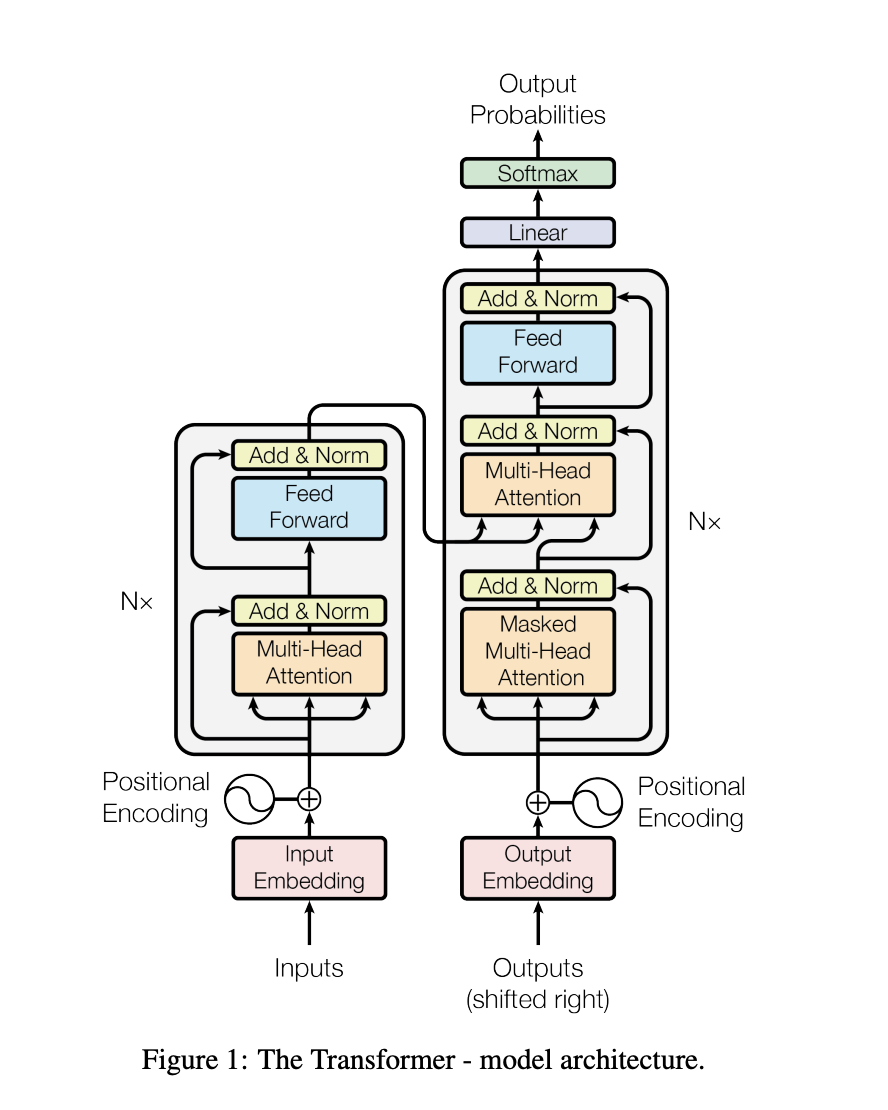

# Parameters and descriptions

- Vocab Size: all the tokens that can be part of the input sequence. sequences are tokenized based on the vocab
- Sequence Length: this is the length of the sentence or sequence fed into the tranformer
- Embedding Size: this is the size of the embedding for each node in the sequence above

S X E dimension for one sequence (S = d_model in the paper)

B X S X E for a batch size of B

From paper:

> To facilitate these residual connections, all sub-layers in the model, as well as the embedding
layers, produce outputs of dimension dmodel = 512.

- Number of Heads: Number of heads in the attenion layer
- Head dimension: Can be calculated from embedding dimension and number of heads: embedding_size // num_heads (this is the same as d_k in the paper)


From paper:

> We call our particular attention "Scaled Dot-Product Attention" (Figure 2). The input consists of
queries and keys of dimension d_k, and values of dimension d_v

Attention

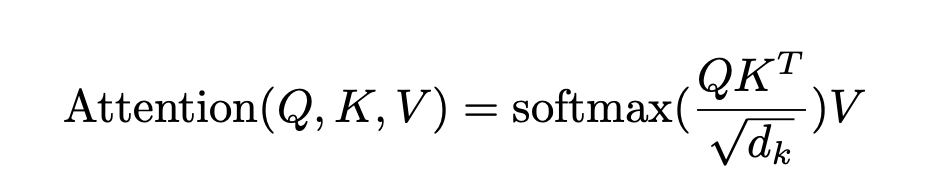

- Dropout: dropout rate after attention layer
- Feed Forward Hidden size: Hidden dimension for feed forward layer

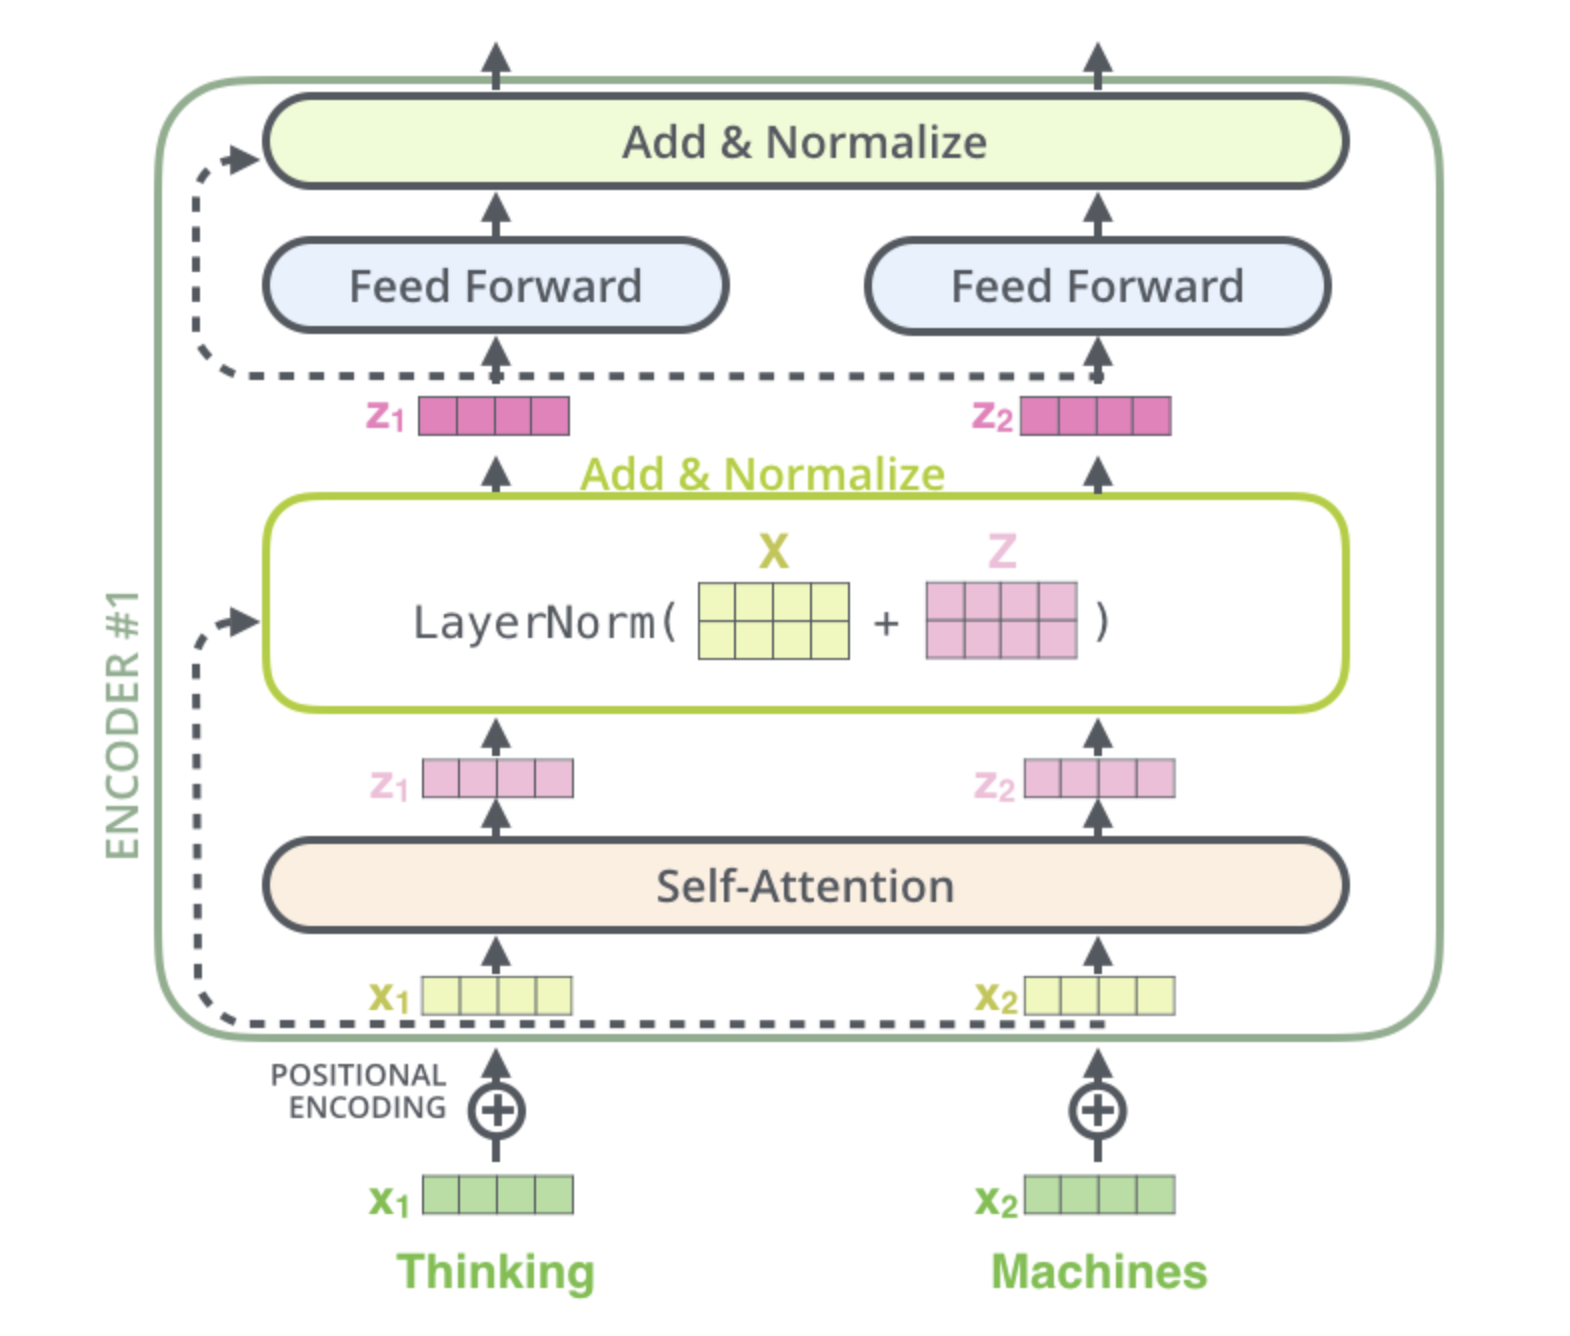

# Encoder

- Input -> Sparse Embedding
- X = Sparse Embedding + Position Embedding
- Calculate A_out = MultiHeadAttn(X)
- A_out = Dropout(A_out)
- L_out = LayerNorm(A_out + X)
- F_out = FeedForwardNN(L_out)
- F_out = Dropout(F_out)
- out = LayerNorm(F_out + L_out)

In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModel

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('gpt2')

# Read the novel from the text file
with open('./data/1984.txt', 'r', encoding='utf-8') as file:
    novel_text = file.read()

/home/ksharma/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
encoded_input = tokenizer(novel_text, return_tensors='pt')
encoded_input

Token indices sequence length is longer than the specified maximum sequence length for this model (141170 > 1024). Running this sequence through the model will result in indexing errors


{'input_ids': tensor([[14126,   352,   628,  ..., 10970, 23578,   198]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]])}

In [4]:
sequence_length = 10

In [5]:
model_inputs = encoded_input["input_ids"].ravel().unfold(0, sequence_length, 1).to(torch.int32)

In [6]:
model_inputs

tensor([[14126,   352,   628,  ...,   257,  6016,  4692],
        [  352,   628,   198,  ...,  6016,  4692,  1110],
        [  628,   198,   198,  ...,  4692,  1110,   287],
        ...,
        [ 2739,   257,  3128,  ...,   198,   198, 10970],
        [  257,  3128,   355,  ...,   198, 10970, 23578],
        [ 3128,   355, 32215,  ..., 10970, 23578,   198]], dtype=torch.int32)

In [7]:
batch = model_inputs[:4, :]

In [8]:
batch

tensor([[14126,   352,   628,   198,   198,  1026,   373,   257,  6016,  4692],
        [  352,   628,   198,   198,  1026,   373,   257,  6016,  4692,  1110],
        [  628,   198,   198,  1026,   373,   257,  6016,  4692,  1110,   287],
        [  198,   198,  1026,   373,   257,  6016,  4692,  1110,   287,  3035]],
       dtype=torch.int32)

# Position Encoding

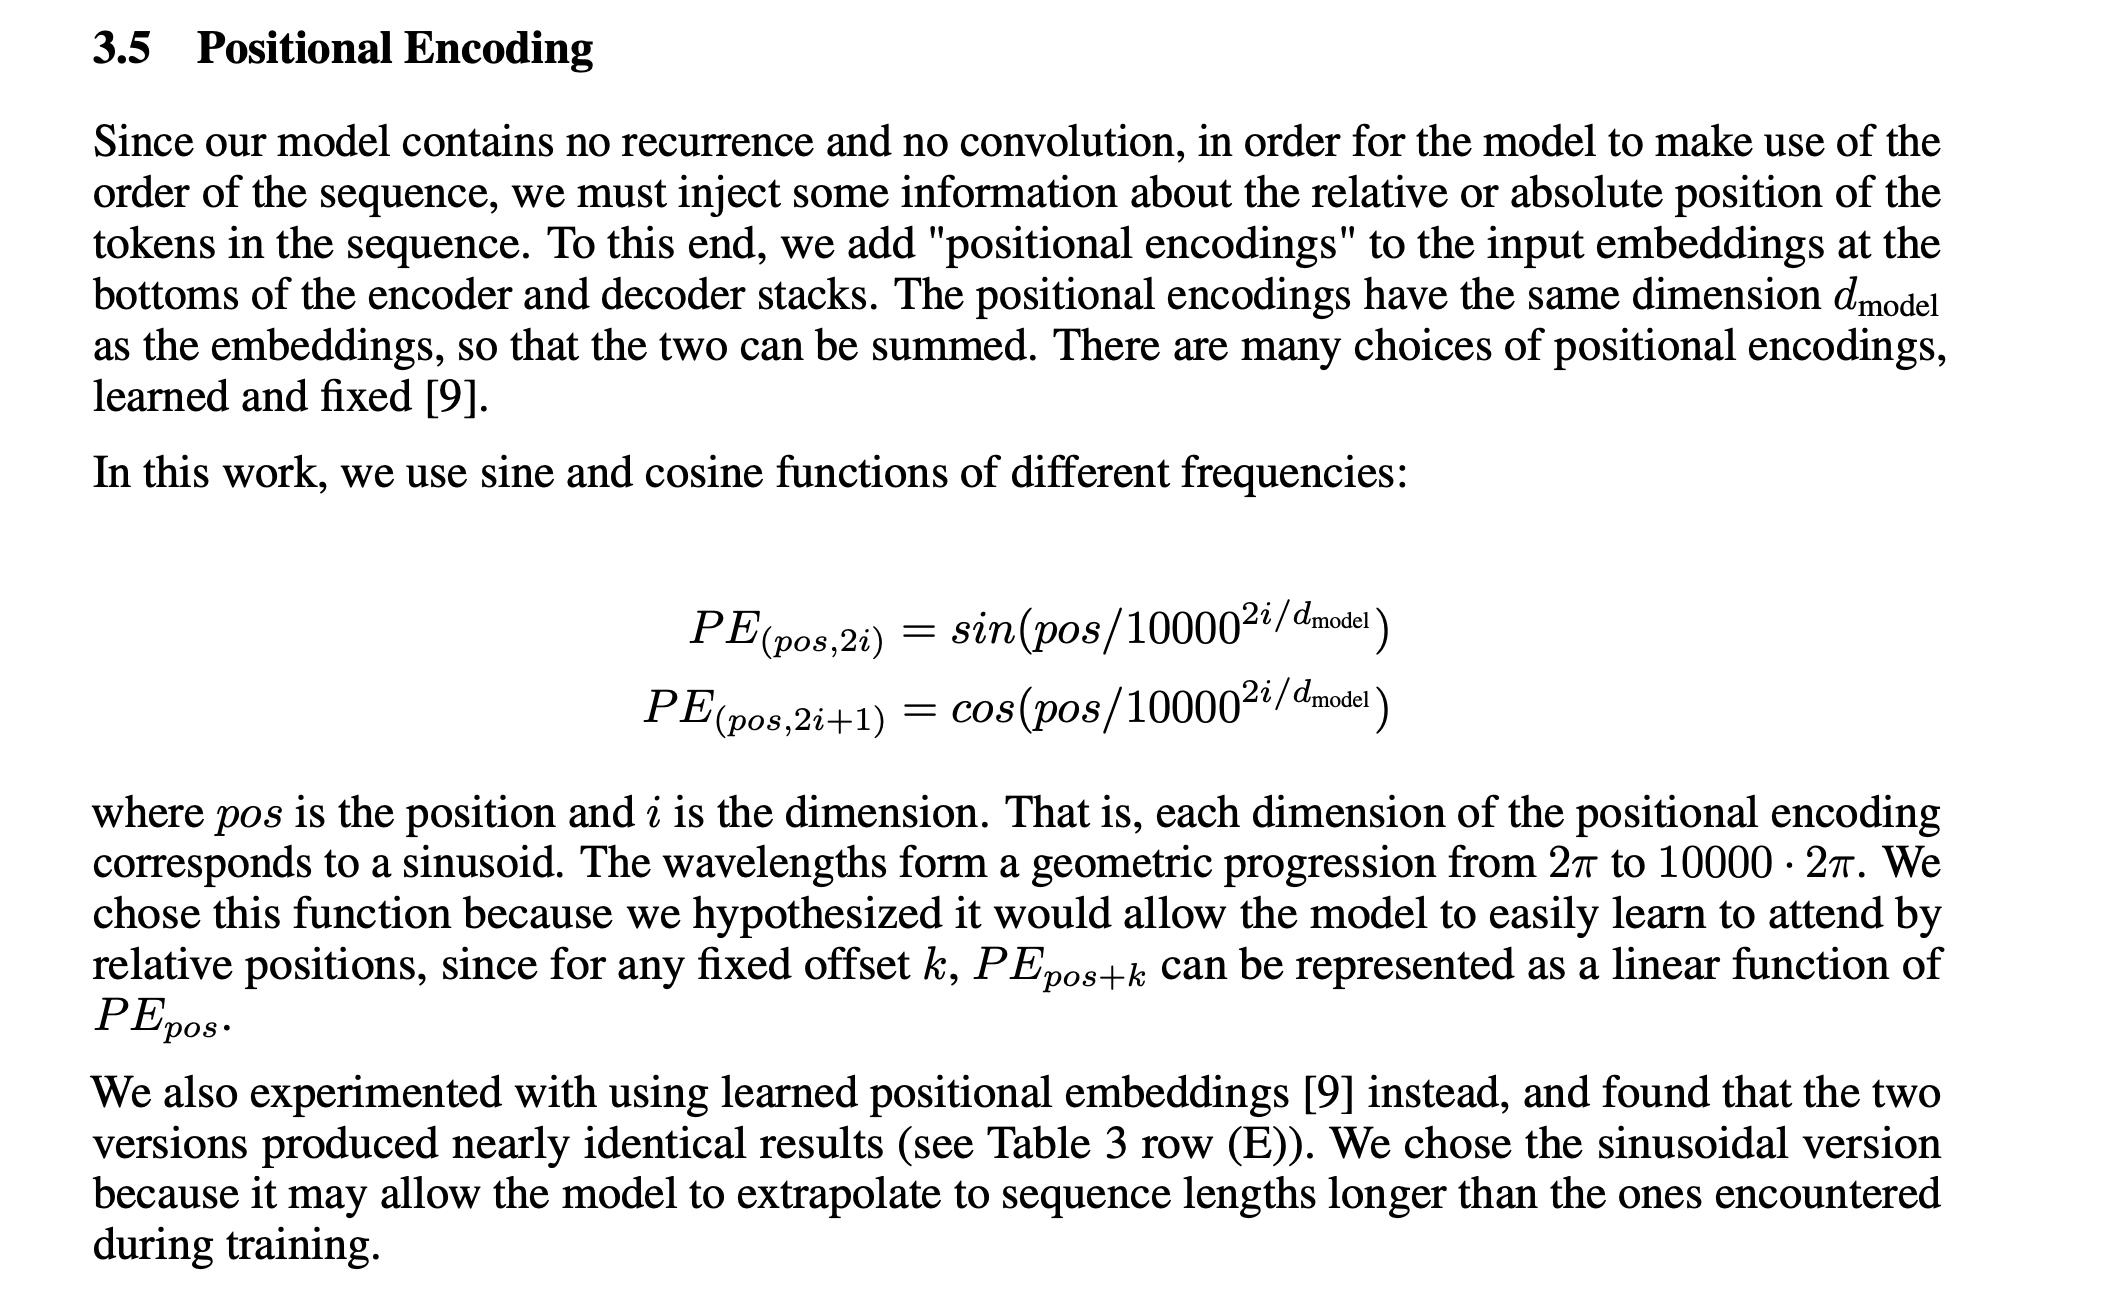

In [9]:
embedding_dimension = 6 # d_model

In [10]:
even_index = torch.arange(0, embedding_dimension, 2)
odd_index = torch.arange(1, embedding_dimension, 2)

In [11]:
even_index

tensor([0, 2, 4])

In [12]:
odd_index

tensor([1, 3, 5])

In [13]:
denominator = torch.pow(10000, even_index / embedding_dimension)
denominator # odd denominator is the same

tensor([  1.0000,  21.5443, 464.1590])

In [14]:
positions = torch.arange(0, sequence_length, 1).reshape(sequence_length, 1)
positions

tensor([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7],
        [8],
        [9]])

In [15]:
even_pe = torch.sin(positions / denominator)
odd_pe = torch.cos(positions / denominator)

In [16]:
even_pe

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.8415,  0.0464,  0.0022],
        [ 0.9093,  0.0927,  0.0043],
        [ 0.1411,  0.1388,  0.0065],
        [-0.7568,  0.1846,  0.0086],
        [-0.9589,  0.2300,  0.0108],
        [-0.2794,  0.2749,  0.0129],
        [ 0.6570,  0.3192,  0.0151],
        [ 0.9894,  0.3629,  0.0172],
        [ 0.4121,  0.4057,  0.0194]])

In [17]:
odd_pe

tensor([[ 1.0000,  1.0000,  1.0000],
        [ 0.5403,  0.9989,  1.0000],
        [-0.4161,  0.9957,  1.0000],
        [-0.9900,  0.9903,  1.0000],
        [-0.6536,  0.9828,  1.0000],
        [ 0.2837,  0.9732,  0.9999],
        [ 0.9602,  0.9615,  0.9999],
        [ 0.7539,  0.9477,  0.9999],
        [-0.1455,  0.9318,  0.9999],
        [-0.9111,  0.9140,  0.9998]])

In [18]:
stacked = torch.stack([even_pe, odd_pe], dim=2)
position_embeddings = torch.flatten(stacked, start_dim=1, end_dim=2)

In [19]:
position_embeddings

tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0464,  0.9989,  0.0022,  1.0000],
        [ 0.9093, -0.4161,  0.0927,  0.9957,  0.0043,  1.0000],
        [ 0.1411, -0.9900,  0.1388,  0.9903,  0.0065,  1.0000],
        [-0.7568, -0.6536,  0.1846,  0.9828,  0.0086,  1.0000],
        [-0.9589,  0.2837,  0.2300,  0.9732,  0.0108,  0.9999],
        [-0.2794,  0.9602,  0.2749,  0.9615,  0.0129,  0.9999],
        [ 0.6570,  0.7539,  0.3192,  0.9477,  0.0151,  0.9999],
        [ 0.9894, -0.1455,  0.3629,  0.9318,  0.0172,  0.9999],
        [ 0.4121, -0.9111,  0.4057,  0.9140,  0.0194,  0.9998]])

# Input Layer

In [20]:
class InputLayer(nn.Module):
    def __init__(self, 
                 num_embeddings: int, 
                 sequence_length: int, 
                 embedding_dimension: int):
        super().__init__()
        self.sequence_length = sequence_length
        self.embedding_dimension = embedding_dimension
        self.input_embeddings = nn.Embedding(num_embeddings=num_embeddings, 
                                             embedding_dim=embedding_dimension)
        self.position_embeddings = self._init_position_embedding(sequence_length, embedding_dimension)
        print(sequence_length, embedding_dimension)

    @staticmethod
    def _init_position_embedding(sl: int, ed: int) -> torch.Tensor:
        even_index = torch.arange(0, embedding_dimension, 2)
        odd_index = torch.arange(1, embedding_dimension, 2)
        denominator = torch.pow(10000, even_index / embedding_dimension)
        even_pe = torch.sin(positions / denominator)
        odd_pe = torch.cos(positions / denominator)
        stacked = torch.stack([even_pe, odd_pe], dim=2)
        return torch.flatten(stacked, start_dim=1, end_dim=2)
        
    
    def forward(self, input: torch.Tensor) -> torch.Tensor:
        emb = self.input_embeddings(input)
        return emb + self.position_embeddings

In [21]:
input_layer = InputLayer(num_embeddings=len(tokenizer.get_vocab()), sequence_length=sequence_length, embedding_dimension=embedding_dimension)

10 6


In [22]:
input_layer

InputLayer(
  (input_embeddings): Embedding(50257, 6)
)

In [23]:
attention_input = input_layer(batch)

In [24]:
attention_input.size()

torch.Size([4, 10, 6])

In [25]:
attention_input

tensor([[[-0.0382,  0.5283, -1.1286,  1.5783, -1.1633,  1.5630],
         [ 1.6665,  1.5086, -0.0096,  0.7304,  0.4731,  0.8309],
         [ 1.4848, -0.1561, -0.3623,  1.9739, -1.0545,  1.3232],
         [ 1.0993, -1.2750,  0.9405,  0.5283, -0.8170, -0.3613],
         [ 0.2014, -0.9387,  0.9863,  0.5208, -0.8149, -0.3613],
         [ 1.8945, -0.4459,  0.2023, -0.2849,  1.7841,  1.8713],
         [-0.4364,  0.4492, -0.0513, -0.2066, -2.3422,  0.9470],
         [ 1.4987, -0.8042,  0.8639,  0.6933, -0.8123,  2.0791],
         [ 0.0714, -0.7184, -0.8596,  2.0719, -0.6759,  1.8260],
         [ 1.1734, -1.0404,  0.7443,  1.6751, -2.0808,  2.3412]],

        [[ 0.8251,  1.9683, -0.0560,  0.7315,  0.4709,  0.8309],
         [ 1.4170,  0.8004, -0.4086,  1.9771, -1.0567,  1.3232],
         [ 1.8675, -0.7012,  0.8944,  0.5337, -0.8192, -0.3613],
         [ 1.0993, -1.2750,  0.9405,  0.5283, -0.8170, -0.3613],
         [ 2.0966, -1.3832,  0.1569, -0.2752,  1.7819,  1.8713],
         [-1.1159, -0.2

# Multi Head Attention

In [28]:
num_heads = 2
head_dimension = embedding_dimension // num_heads
if embedding_dimension % num_heads != 0:
    raise ValueError("embedding_dimension should be divisible by num_heads")

In [29]:
# split up input into Q, K, V
qkv_layer = nn.Linear(embedding_dimension, 3 * embedding_dimension)
with torch.no_grad():
    qkv_layer.weight.fill_(2)

qkv = qkv_layer(attention_input)

In [30]:
qkv.size()

torch.Size([4, 10, 18])

In [31]:
input_shape = attention_input.shape
input_shape = input_shape[:-1] + (num_heads, 3 * head_dimension)
input_shape

torch.Size([4, 10, 2, 9])

In [32]:
qkv = qkv.reshape(*input_shape)
qkv = qkv.permute(0, 2, 1, 3)

In [33]:
qkv.size() # batch_size, num_head, sequence_length, 3 * head_dim

torch.Size([4, 2, 10, 9])

In [34]:
q, k, v = qkv.chunk(3, dim=-1)

In [35]:
for masked in [True, False]:
    if masked:
        mask = torch.full((sequence_length, sequence_length),
                          -torch.inf)
        mask = torch.triu(mask, diagonal=1)
    else:
        mask = torch.zeros((sequence_length, sequence_length))
    print(mask)

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [

## Scaled Dot Product Attention

In [48]:
# here we take the query and key head blocks and do the scaled multiply

scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(head_dimension)

# here we add the masks for backward looking bias (for encoder the masks are all 0 since we use both forward and backward context)
scores += mask

# softmax(QK/sqrt(d_model))
attention = torch.softmax(scores, dim=-1)

In [49]:
attention.size()

torch.Size([4, 2, 10, 10])

In [50]:
# last part in the attention calculation where we multiply with values
values = torch.matmul(attention, v)

In [51]:
values.size()

torch.Size([4, 2, 10, 3])

In [52]:
values = values.transpose(1, 2).contiguous()
print("After transposing the head and sequence dims", values.size())
values = values.view(*values.shape[:2], -1)
print("After concating all the head dims", values.size())

After transposing the head and sequence dims torch.Size([4, 10, 2, 3])
After concating all the head dims torch.Size([4, 10, 6])


In [55]:
# final linear layer in the attention

attn_linear_layer = nn.Linear(embedding_dimension, embedding_dimension)
attn_out = attn_linear_layer(values_out)
print("output from attention has size", attn_out.size())
attn_out

output from attention has size torch.Size([4, 10, 6])


tensor([[[-3.9014, -2.5143,  0.5328,  2.1713, 11.6392, -4.5111],
         [-3.9261, -2.5294,  0.5359,  2.1826, 11.7051, -4.5360],
         [-3.9235, -2.5278,  0.5356,  2.1814, 11.6980, -4.5333],
         [-2.9408, -1.9877,  0.5475,  1.6745,  8.8760, -3.4817],
         [ 1.7852,  1.0139, -0.2578, -0.4185, -3.4584,  1.2042],
         [-3.9260, -2.5294,  0.5359,  2.1826, 11.7050, -4.5360],
         [ 1.8151,  1.0338, -0.2649, -0.4310, -3.5336,  1.2330],
         [-3.9244, -2.5284,  0.5357,  2.1818, 11.7005, -4.5343],
         [-3.9097, -2.5193,  0.5338,  2.1751, 11.6612, -4.5194],
         [-3.9217, -2.5267,  0.5354,  2.1806, 11.6933, -4.5315]],

        [[-3.5661, -2.3060,  0.4857,  2.0187, 10.7494, -4.1742],
         [-3.5661, -2.3060,  0.4857,  2.0187, 10.7494, -4.1742],
         [-3.5613, -2.3031,  0.4852,  2.0165, 10.7365, -4.1694],
         [-2.7212, -1.8198,  0.4495,  1.6014,  8.3896, -3.2900],
         [-3.5661, -2.3060,  0.4857,  2.0187, 10.7494, -4.1742],
         [ 2.9829,  1.7

In [57]:
attn_out.size()

torch.Size([4, 10, 6])

# Layer Normalization

In [62]:
# there is already a layer norm implementation in pytorch

layer_norm = nn.LayerNorm(embedding_dimension)
layer_norm_out = layer_norm(attn_out)
layer_norm_out.size()

torch.Size([4, 10, 6])

In [86]:
layer_norm_out[:, :, 0]

tensor([[-0.8153, -0.8156, -0.8156, -0.8085,  1.0473, -0.8156,  1.0442, -0.8156,
         -0.8154, -0.8156],
        [-0.8104, -0.8104, -0.8104, -0.7993, -0.8104,  0.9674, -0.8104, -0.8104,
         -0.8104, -0.8104],
        [-0.8103, -0.8102, -0.8101, -0.8104,  0.9485, -0.8101, -0.8101, -0.8104,
         -0.8104, -0.8102],
        [-0.8271, -0.8271, -0.8271,  0.9603, -0.8267, -0.8244, -0.8271, -0.8271,
         -0.8271, -0.8271]], grad_fn=<SelectBackward0>)

In [92]:
# let;s calculate it from scratch
attn_out_mean = attn_out.mean(-1, keepdim=True)
attn_out_var = torch.pow(attn_out - attn_out_mean, 2).mean(-1, keepdims=True)
attn_out_std = torch.sqrt(attn_out_var + layer_norm.eps)
ln_out = (attn_out - attn_out_mean) / attn_out_std
ln_out[:, :, 0]

tensor([[-0.8153, -0.8156, -0.8156, -0.8085,  1.0473, -0.8156,  1.0442, -0.8156,
         -0.8154, -0.8156],
        [-0.8104, -0.8104, -0.8104, -0.7993, -0.8104,  0.9674, -0.8104, -0.8104,
         -0.8104, -0.8104],
        [-0.8103, -0.8102, -0.8101, -0.8104,  0.9485, -0.8101, -0.8101, -0.8104,
         -0.8104, -0.8102],
        [-0.8271, -0.8271, -0.8271,  0.9603, -0.8267, -0.8244, -0.8271, -0.8271,
         -0.8271, -0.8271]], grad_fn=<SelectBackward0>)

# Feed Forward Network

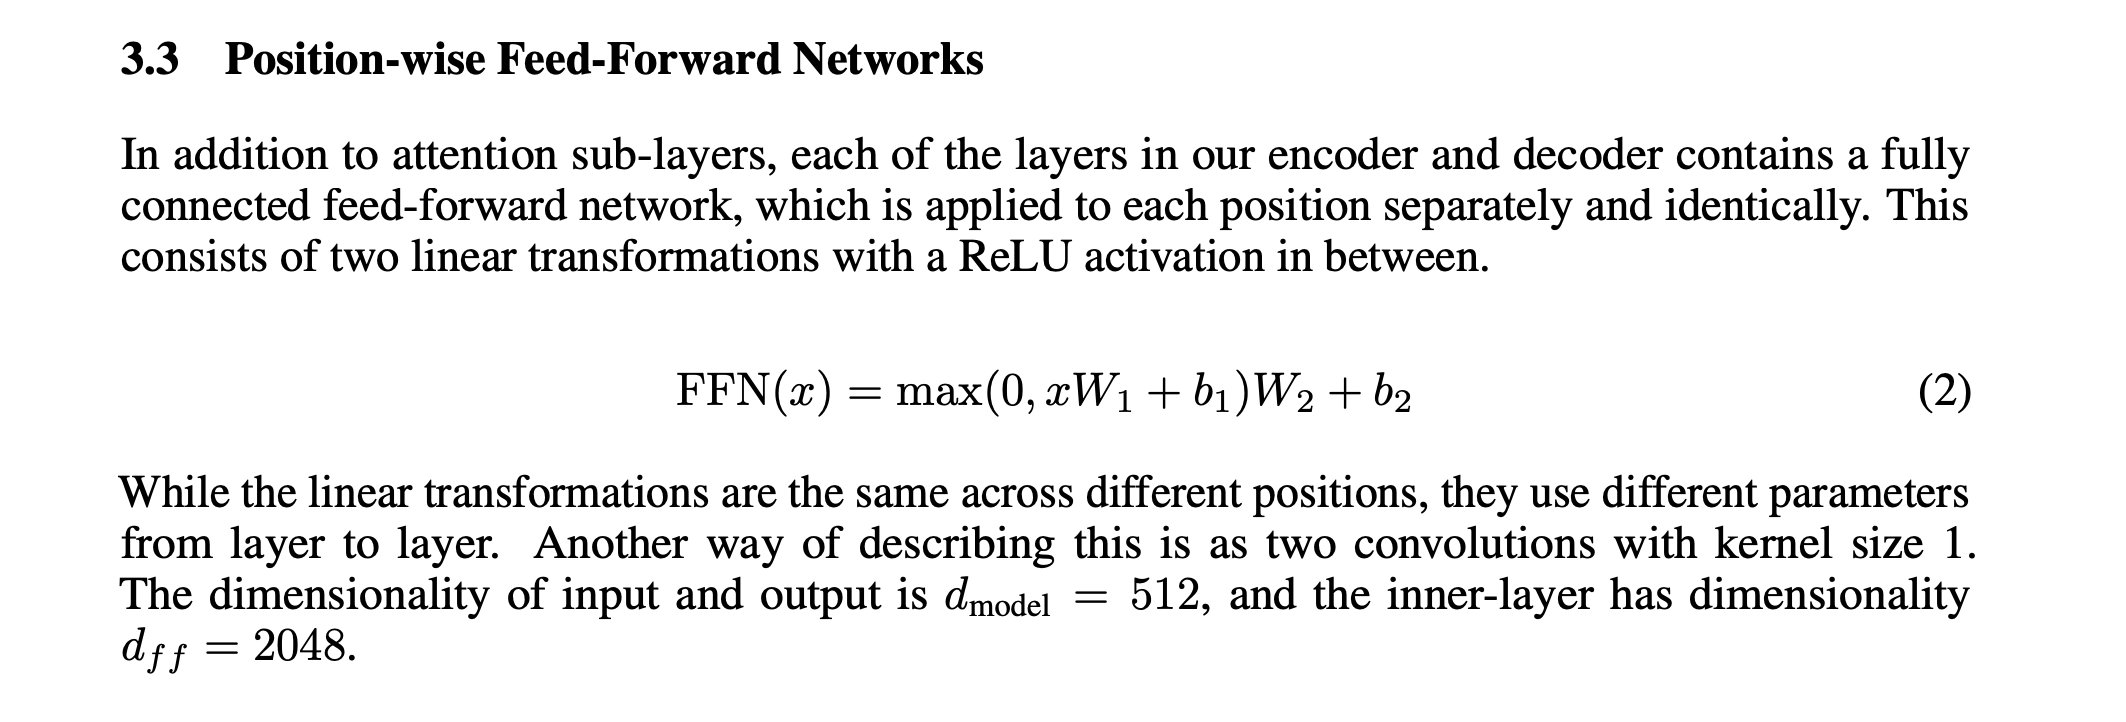

> The dimensionality of input and output is dmodel = 512, and the inner-layer has dimensionality
df f = 2048.

In [98]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, 
                 embedding_dimension: float, 
                 hidden_dimension: float, 
                 drop_prop: float):
        super().__init__()
        self.linear1 = nn.Linear(in_features=embedding_dimension, out_features=hidden_dimension)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout()
        self.linear2 = nn.Linear(in_features=hidden_dimension, out_features=embedding_dimension)

    def forward(self, x):
        return self.linear2(self.dropout(self.activation(self.linear1(x))))

In [99]:
ffn_hidden_dimension = 12
dropout_prob = 0.1
ffn = FeedForwardNetwork(embedding_dimension=embedding_dimension, hidden_dimension=ffn_hidden_dimension, drop_prop=dropout_prob)

In [102]:
ffn_out = ffn(layer_norm_out)
ffn_out.size()

torch.Size([4, 10, 6])

At this point, ffn output also goes through a layer normalization

In [103]:
ffn_layer_norm = nn.LayerNorm(embedding_dimension)
ffn_layer_norm_out = ffn_layer_norm(ffn_out)
ffn_layer_norm_out.size()

torch.Size([4, 10, 6])

In [104]:
ffn_layer_norm_out

tensor([[[-1.1136,  0.5701,  1.1559, -0.9352, -0.8805,  1.2034],
         [-1.5431,  0.1415,  0.6870, -0.6857, -0.2153,  1.6155],
         [-1.3030,  0.8635,  0.3625, -0.7784, -0.6797,  1.5351],
         [-1.9266, -0.3325,  0.6218,  0.1461,  0.1731,  1.3181],
         [-0.3211, -0.9690,  2.0612,  0.0801, -0.8383, -0.0129],
         [-1.1136,  0.5701,  1.1559, -0.9352, -0.8805,  1.2034],
         [-1.8052, -0.3676,  1.5367,  0.0890,  0.0676,  0.4795],
         [-1.1136,  0.5701,  1.1559, -0.9352, -0.8805,  1.2034],
         [-1.3725,  0.2978,  0.3347, -0.6945, -0.3790,  1.8135],
         [-1.9229, -0.3232,  0.6051,  0.1428,  0.1632,  1.3351]],

        [[-1.9094, -0.6028,  1.1112,  0.2397,  0.4756,  0.6857],
         [-0.9420,  1.0754,  1.0936, -0.9375, -1.1036,  0.8141],
         [-0.9421,  1.0754,  1.0936, -0.9375, -1.1035,  0.8141],
         [-1.5654, -1.0150,  0.4258,  0.2063,  0.5291,  1.4192],
         [-1.5577, -1.1966,  0.8053,  0.2753,  0.7474,  0.9262],
         [-0.1798, -0.9